In [1]:
import connectorx as cx
import pandas as pd
import numpy as np
import os
import duckdb
from datetime import datetime
import glob
import multiprocessing as mp
from functools import partial
import time

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

In [2]:
raw_path = "/data/home/lexuanchen/Factors/Order/Signal/Six_Times_Divergence/ask_main_1000_1430.csv"

p01p99_path = "/data/home/lexuanchen/Factors/Order/Signal/1_100_Percent_ASK_P01_P99_Price_Divergence/20d_ask_main_1000_1430_p01_p99.csv"

p05p95_path = "/data/home/lexuanchen/Factors/Order/Signal/1_100_Percent_ASK_P05_P95_Price_Divergence/20d_ask_main_1000_1430_p05_p95.csv"

order_path = "/data/cephfs/order/20250530.parquet"

raw_df = pd.read_csv(raw_path)
p01p99_df = pd.read_csv(p01p99_path)
p05p95_df = pd.read_csv(p05p95_path)
# order_df = pd.read_parquet(order_path)

In [56]:
raw_df = pd.read_parquet("/data/home/lexuanchen/AskMainDebug/20d_raw_alpha")

p01p99_df = pd.read_parquet("/data/home/lexuanchen/AskMainDebug/20d_p01p99_alpha")

p05p95_df = pd.read_parquet("/data/home/lexuanchen/AskMainDebug/20d_p05p95_alpha")


In [57]:
print(raw_df.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3749269 entries, (Timestamp('2021-05-24 00:00:00'), '000001') to (Timestamp('2024-12-30 00:00:00'), '689009')
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   factor           float64
 1   1D               float64
 2   5D               float64
 3   20D              float64
 4   group            object 
 5   factor_quantile  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 186.1+ MB
None


In [60]:
raw_df['factor_quantile'] = raw_df['factor_quantile'].astype('int')
raw_df['factor_quantile'].describe()

count    3.749269e+06
mean     5.499803e+00
std      2.872766e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      8.000000e+00
max      1.000000e+01
Name: factor_quantile, dtype: float64

In [61]:
# 计算每个分组每天的平均因子值
def calculate_daily_average(df, factor_col, decile):
    
    decile_df = df[df['factor_quantile'] == decile]
    daily_avg = decile_df.groupby('date')[factor_col].mean().reset_index()
    return daily_avg


def calculate_daily_average_return(df, decile):
    decile_df = df[df['factor_quantile'] == decile]
    daily_avg = decile_df.groupby('date')['1D'].mean().reset_index()
    return daily_avg

# 第一组(decile=1)的平均收益率
raw_decile1_returns = calculate_daily_average_return(raw_df, 1)
p01p99_decile1_returns = calculate_daily_average_return(p01p99_df, 1)
p05p95_decile1_returns = calculate_daily_average_return(p05p95_df, 1)

# 第十组(decile=10)的平均收益率
raw_decile10_returns = calculate_daily_average_return(raw_df, 10)
p01p99_decile10_returns = calculate_daily_average_return(p01p99_df, 10)
p05p95_decile10_returns = calculate_daily_average_return(p05p95_df, 10)

# 合并数据以便计算差值
decile1_merged = pd.merge(raw_decile1_returns, p01p99_decile1_returns, on='date', suffixes=('_raw', '_p01p99'))
decile1_merged = pd.merge(decile1_merged, p05p95_decile1_returns, on='date')
decile1_merged.rename(columns={'1D': '1D_p05p95'}, inplace=True)

decile10_merged = pd.merge(raw_decile10_returns, p01p99_decile10_returns, on='date', suffixes=('_raw', '_p01p99'))
decile10_merged = pd.merge(decile10_merged, p05p95_decile10_returns, on='date')
decile10_merged.rename(columns={'1D': '1D_p05p95'}, inplace=True)


# 计算差值
decile1_merged['raw_minus_p01p99'] = decile1_merged['1D_raw'] - decile1_merged['1D_p01p99']
decile1_merged['raw_minus_p05p95'] = decile1_merged['1D_raw'] - decile1_merged['1D_p05p95']

decile10_merged['raw_minus_p01p99'] = decile10_merged['1D_raw'] - decile10_merged['1D_p01p99']
decile10_merged['raw_minus_p05p95'] = decile10_merged['1D_raw'] - decile10_merged['1D_p05p95']

In [62]:
decile1_merged.head(10)

,date,1D_raw,1D_p01p99,1D_p05p95,raw_minus_p01p99,raw_minus_p05p95
0,2021-05-24,0.010748,0.009701,0.007646,0.001047,0.003102
1,2021-05-25,0.008525,0.009593,0.004350,-0.001068,0.004176
2,2021-05-26,-0.007718,-0.008820,-0.006046,0.001102,-0.001672
3,2021-05-27,0.013923,0.014579,0.007732,-0.000656,0.006190
4,2021-05-30,0.011946,0.011598,0.005746,0.000348,0.006200
5,2021-05-31,-0.011177,-0.011121,-0.010301,-0.000057,-0.000877
6,2021-06-01,-0.002883,-0.003552,-0.006271,0.000669,0.003388
7,2021-06-02,0.001967,0.002768,-0.003513,-0.000801,0.005480
8,2021-06-03,0.011142,0.011087,0.004361,0.000056,0.006781
9,2021-06-06,0.005923,0.006829,0.001339,-0.000906,0.004584


In [63]:
# 计算累积收益率
def calculate_log_cumulative_returns(df, return_columns):
    result = df.copy()
    for col in return_columns:
        result[f'{col}_cumulative'] =  result[f'{col}'].cumsum() - 1
    return result


# 计算第一组的累积收益率
decile1_return_cols = ['1D_raw', '1D_p01p99', '1D_p05p95', 
                       'raw_minus_p01p99', 'raw_minus_p05p95']
decile1_cumulative = calculate_log_cumulative_returns(decile1_merged, decile1_return_cols)

# 计算第十组的累积收益率
decile10_return_cols = ['1D_raw', '1D_p01p99', '1D_p05p95', 
                        'raw_minus_p01p99', 'raw_minus_p05p95']
decile10_cumulative = calculate_log_cumulative_returns(decile10_merged, decile10_return_cols)


In [64]:
# 在绘图前将每个累积收益率序列的第一个值设为0
def normalize_cumulative_returns(df, cumulative_columns):
    result = df.copy()
    for col in cumulative_columns:
        # 获取第一个非NaN值
        first_value = result[col].iloc[0]
        # 将所有值减去第一个值，使序列从0开始
        result[col] = result[col] - first_value
    return result

# 调整第一组的累积收益率，使其从0开始
decile1_cumulative_cols = [
    '1D_raw_cumulative', 
    '1D_p01p99_cumulative', 
    '1D_p05p95_cumulative', 
    'raw_minus_p01p99_cumulative', 
    'raw_minus_p05p95_cumulative'
]
decile1_cumulative = normalize_cumulative_returns(decile1_cumulative, decile1_cumulative_cols)

# 调整第十组的累积收益率，使其从0开始
decile10_cumulative_cols = [
    '1D_raw_cumulative', 
    '1D_p01p99_cumulative', 
    '1D_p05p95_cumulative', 
    'raw_minus_p01p99_cumulative', 
    'raw_minus_p05p95_cumulative'
]
decile10_cumulative = normalize_cumulative_returns(decile10_cumulative, decile10_cumulative_cols)

In [35]:
decile10_cumulative.head()

,date,1D_raw,1D_p01p99,1D_p05p95,raw_minus_p01p99,raw_minus_p05p95,1D_raw_cumulative,1D_p01p99_cumulative,1D_p05p95_cumulative,raw_minus_p01p99_cumulative,raw_minus_p05p95_cumulative
0,2021-05-18,-0.003091,-0.003175,-0.006965,0.000084,0.003874,0.000000,0.000000,0.000000,0.000000,0.000000
1,2021-05-19,0.003367,0.003541,0.001763,-0.000174,0.001604,0.003367,0.003541,0.001763,-0.000174,0.001604
2,2021-05-20,0.008987,0.007720,0.001240,0.001266,0.007747,0.012354,0.011262,0.003003,0.001092,0.009351
3,2021-05-23,0.005796,0.003700,0.003569,0.002096,0.002226,0.018149,0.014962,0.006573,0.003188,0.011577
4,2021-05-24,0.010035,0.009406,0.006080,0.000630,0.003956,0.028185,0.024367,0.012653,0.003817,0.015532


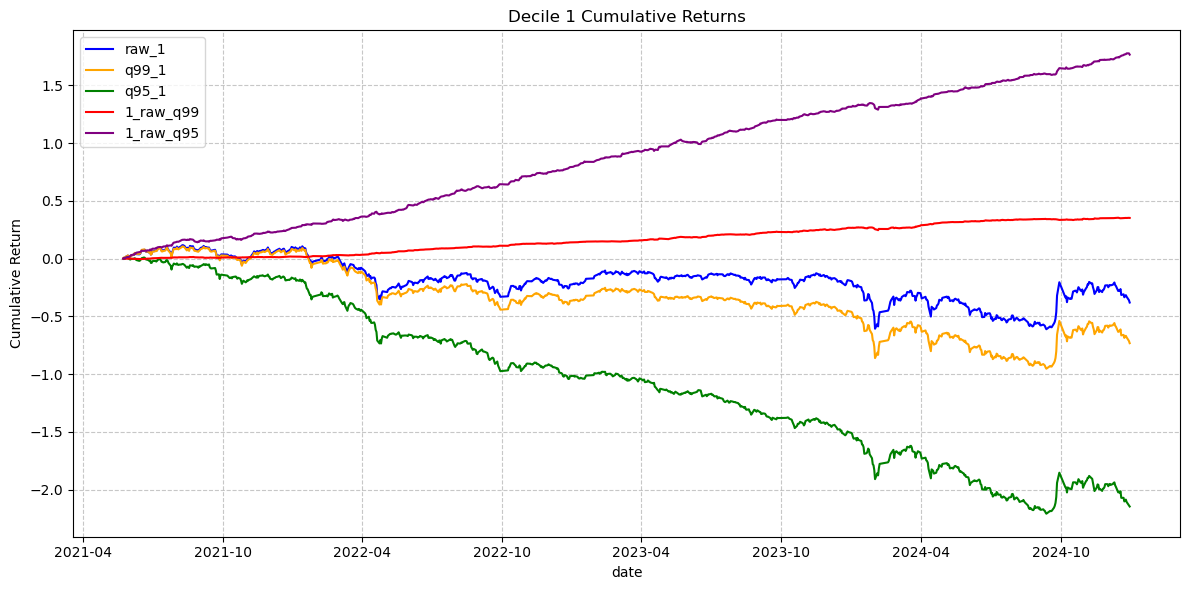

In [65]:
# 绘制第一组的累积收益率图表
plt.figure(figsize=(12, 6))
plt.plot(decile1_cumulative['date'], decile1_cumulative['1D_raw_cumulative'], label='raw_1', color='blue')
plt.plot(decile1_cumulative['date'], decile1_cumulative['1D_p01p99_cumulative'], label='q99_1', color='orange')
plt.plot(decile1_cumulative['date'], decile1_cumulative['1D_p05p95_cumulative'], label='q95_1', color='green')
plt.plot(decile1_cumulative['date'], decile1_cumulative['raw_minus_p01p99_cumulative'], label='1_raw_q99', color='red')
plt.plot(decile1_cumulative['date'], decile1_cumulative['raw_minus_p05p95_cumulative'], label='1_raw_q95', color='purple')

plt.title('Decile 1 Cumulative Returns')
plt.xlabel('date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('decile1_cumulative_returns.png')
plt.show()

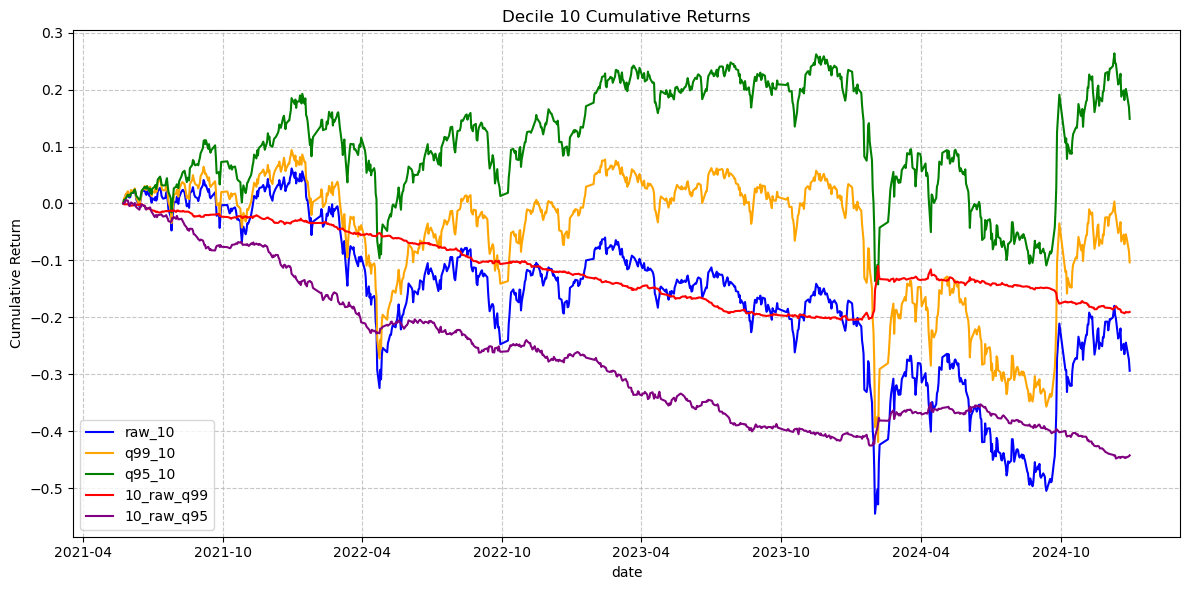

In [66]:
# 绘制第十组的累积收益率图表
plt.figure(figsize=(12, 6))
plt.plot(decile10_cumulative['date'], decile10_cumulative['1D_raw_cumulative'], label='raw_10', color='blue')
plt.plot(decile10_cumulative['date'], decile10_cumulative['1D_p01p99_cumulative'], label='q99_10', color='orange')
plt.plot(decile10_cumulative['date'], decile10_cumulative['1D_p05p95_cumulative'], label='q95_10', color='green')
plt.plot(decile10_cumulative['date'], decile10_cumulative['raw_minus_p01p99_cumulative'], label='10_raw_q99', color='red')
plt.plot(decile10_cumulative['date'], decile10_cumulative['raw_minus_p05p95_cumulative'], label='10_raw_q95', color='purple')

plt.title('Decile 10 Cumulative Returns')
plt.xlabel('date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('decile10_cumulative_returns.png')
plt.show()

In [47]:
raw_df_reset = raw_df.reset_index()
raw_df_reset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3763309 entries, 0 to 3763308
Data columns (total 8 columns):
 #   Column           Dtype         
---  ------           -----         
 0   date             datetime64[ns]
 1   asset            object        
 2   factor           float64       
 3   1D               float64       
 4   5D               float64       
 5   20D              float64       
 6   group            object        
 7   factor_quantile  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 229.7+ MB


In [ ]:
import pandas as pd
import numpy as np

def analyze_decile_transitions(raw_df, p01p99_df, p05p95_df, focus_decile=1):
    """
    Analyze where stocks from a specific decile in the raw grouping go after two different winsorization methods
    
    Parameters:
    raw_df: Original grouped data
    p01p99_df: Data after 1%-99% winsorization
    p05p95_df: Data after 5%-95% winsorization
    focus_decile: Target decile to focus on (1 for short side, 10 for long side)
    
    Returns:
    transition_matrix: Shows stock movement from original grouping to both winsorization methods
    return_matrix: Shows return contribution in each cell
    """
    # Initialize transition and return matrices
    transition_matrix = pd.DataFrame(0, index=range(1, 11), columns=range(1, 11))
    return_matrix = pd.DataFrame(0.0, index=range(1, 11), columns=range(1, 11))


    raw_df = raw_df.reset_index()
    p01p99_df = p01p99_df.reset_index()
    p05p95_df = p05p95_df.reset_index()
    
    # Get all dates
    dates = sorted(raw_df['date'].unique())
    
    for date in dates:
        # Get data for current date
        raw_day = raw_df[raw_df['date'] == date]
        p01p99_day = p01p99_df[p01p99_df['date'] == date]
        p05p95_day = p05p95_df[p05p95_df['date'] == date]
        
        # Get stocks in focus_decile from raw grouping
        focus_stocks = raw_day[raw_day['factor_quantile'] == focus_decile]['asset'].unique()
        
        for stock in focus_stocks:
            # Get deciles for this stock in both winsorization methods
            p01p99_decile = p01p99_day[p01p99_day['asset'] == stock]['factor_quantile'].values
            p05p95_decile = p05p95_day[p05p95_day['asset'] == stock]['factor_quantile'].values
            
            # If stock exists in both methods
            if len(p01p99_decile) > 0 and len(p05p95_decile) > 0:
                p01p99_decile = int(p01p99_decile[0])
                p05p95_decile = int(p05p95_decile[0])
                
                # Update transition matrix
                transition_matrix.loc[p01p99_decile, p05p95_decile] += 1
                
                # Update return contribution matrix
                stock_return = raw_day[raw_day['asset'] == stock]['1D'].values[0]
                return_matrix.loc[p01p99_decile, p05p95_decile] += stock_return
    
    return transition_matrix, return_matrix

def analyze_both_extremes(raw_with_returns, p01p99_with_returns, p05p95_with_returns):
    """
    Analyze transitions for both short and long sides
    """
    # Analyze short side (decile=1)
    bottom_transition, bottom_return = analyze_decile_transitions(
        raw_with_returns, p01p99_with_returns, p05p95_with_returns, focus_decile=1
    )
    
    # Analyze long side (decile=10)
    top_transition, top_return = analyze_decile_transitions(
        raw_with_returns, p01p99_with_returns, p05p95_with_returns, focus_decile=10
    )
    
    # Calculate average return contribution
    bottom_avg_return = bottom_return / bottom_transition.replace(0, np.nan)
    top_avg_return = top_return / top_transition.replace(0, np.nan)
    
    return {
        'bottom_transition': bottom_transition,
        'bottom_return': bottom_return,
        'bottom_avg_return': bottom_avg_return,
        'top_transition': top_transition,
        'top_return': top_return,
        'top_avg_return': top_avg_return
    }

# Run the analysis
results = analyze_both_extremes(raw_df, p01p99_df, p05p95_df)

# Print results
print("Short Side (Decile=1) Transition Matrix:")
print("(Rows: p01p99 deciles, Columns: p05p95 deciles)")
print(results['bottom_transition'])
print("\n")

print("Long Side (Decile=10) Transition Matrix:")
print("(Rows: p01p99 deciles, Columns: p05p95 deciles)")
print(results['top_transition'])
print("\n")

# Calculate row and column sums
print("Short Side Row Sums (p01p99 decile distribution):")
print(results['bottom_transition'].sum(axis=1))
print("\n")

print("Short Side Column Sums (p05p95 decile distribution):")
print(results['bottom_transition'].sum(axis=0))
print("\n")

print("Long Side Row Sums (p01p99 decile distribution):")
print(results['top_transition'].sum(axis=1))
print("\n")

print("Long Side Column Sums (p05p95 decile distribution):")
print(results['top_transition'].sum(axis=0))
print("\n")

# Print return contribution matrices
print("Short Side (Decile=1) Return Contribution Matrix:")
print(results['bottom_return'])
print("\n")

print("Long Side (Decile=10) Return Contribution Matrix:")
print(results['top_return'])
print("\n")

# Print average return matrices
print("Short Side (Decile=1) Average Return Matrix:")
print(results['bottom_avg_return'])
print("\n")

print("Long Side (Decile=10) Average Return Matrix:")
print(results['top_avg_return'])


# 计算行和（忽略NaN值）
short_side_row_sums = np.nansum(results['bottom_avg_return'], axis=1)
long_side_row_sums = np.nansum(results['top_avg_return'], axis=1)

# 计算列和（忽略NaN值）
short_side_col_sums = np.nansum(results['bottom_avg_return'], axis=0)
long_side_col_sums = np.nansum(results['top_avg_return'], axis=0)

# 创建结果表格
results = pd.DataFrame({
    'Short Side Row Sums (decile=1)': short_side_row_sums,
    'Long Side Row Sums (decile=10)': long_side_row_sums
})

col_results = pd.DataFrame({
    'Short Side Column Sums (decile=1)': short_side_col_sums,
    'Long Side Column Sums (decile=10)': long_side_col_sums
})

print("\np01p99:")
print(results)
print("\np05p95:")
print(col_results)


Short Side (Decile=1) Transition Matrix:
(Rows: p01p99 deciles, Columns: p05p95 deciles)
        1      2      3      4      5      6      7     8     9     10
1   122214  52272  31945  22612  16969  13781  10725  8087  5447  2511
2     2149   4599   4992   5461   6000   6453   6145  6089  5285  3470
3      195    716   1014   1247   1737   1877   2344  2410  2442  1910
4       36    251    449    624    879   1025   1119  1247  1433  1392
5        6     84    259    352    447    586    728   771   898  1052
6        0     32    102    173    253    362    459   467   563   793
7        0      4     58     91    147    240    316   318   489   554
8        0      0     12     61     89    148    248   269   400   455
9        0      0      0     14     29     48    108   149   293   318
10       0      0      0      0      0      8     29    65   148   260


Long Side (Decile=10) Transition Matrix:
(Rows: p01p99 deciles, Columns: p05p95 deciles)
    1    2     3     4     5      6    

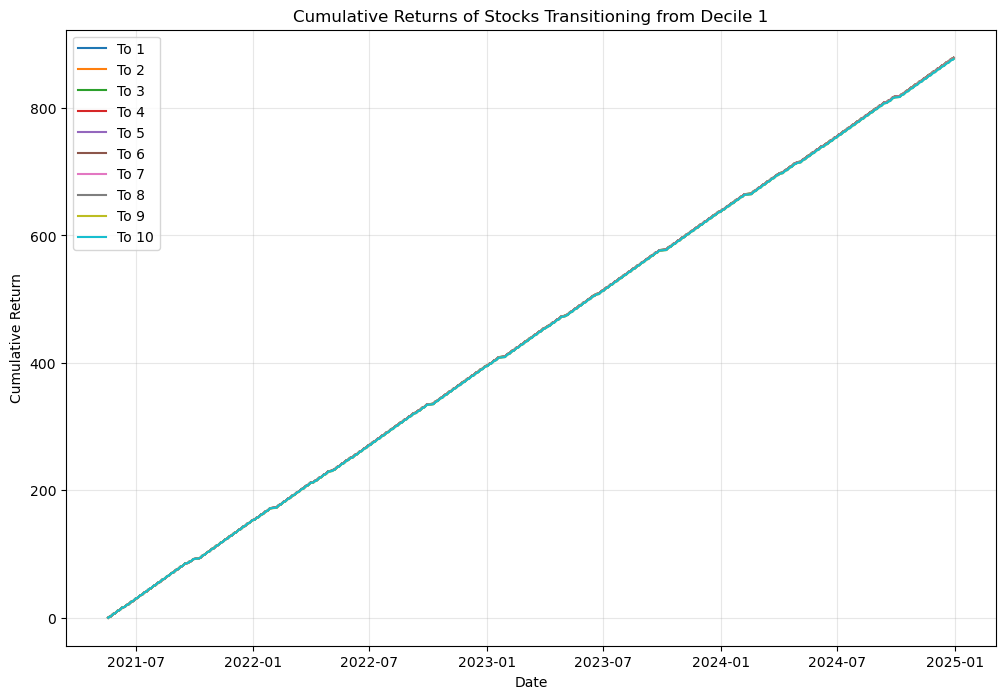

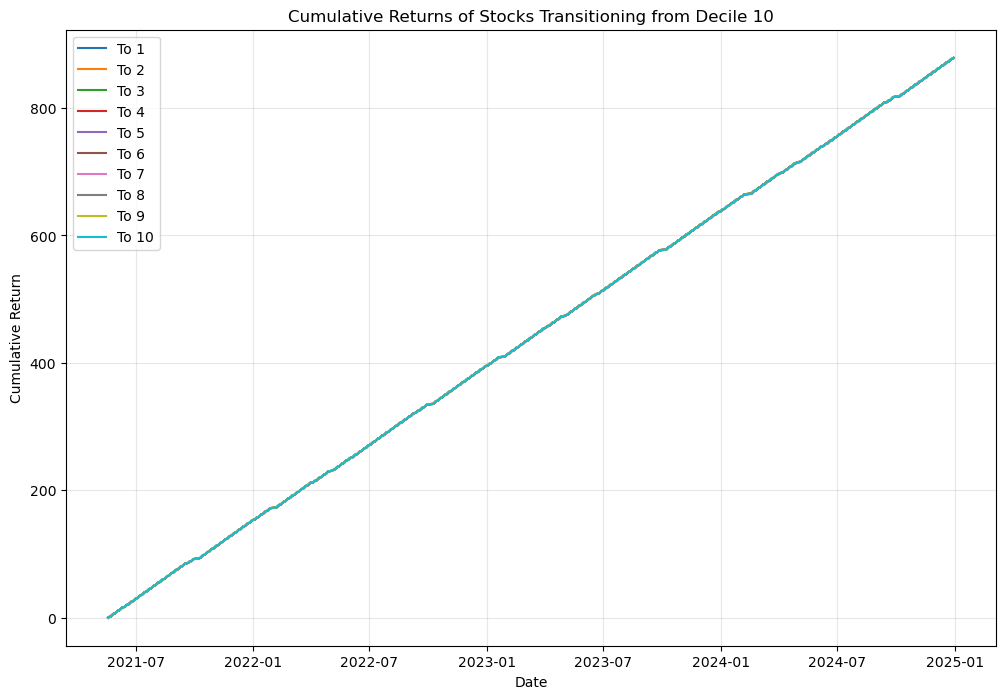

In [50]:
def track_decile_transitions_returns(df, start_decile, return_window='1D'):
    """
    跟踪从特定分组(factor_quantile)转移到各个分组的股票的累计收益率
    
    Parameters:
    df: DataFrame with MultiIndex (date, asset)
    start_decile: 起始分组 (1 or 10)
    return_window: 使用的收益率列名 ('1D', '5D', '20D')
    
    Returns:
    DataFrame with cumulative returns for each transition path
    """
    # 重置索引以便于操作
    df_reset = df.reset_index()
    
    
    # 排序日期
    all_dates = sorted(df_reset['date'].unique())
    
    # 创建一个字典存储每个目标分组的日收益率序列
    transition_returns = {i: [] for i in range(1, 11)}
    
    # 对每个日期（除了最后一个）进行循环
    for i in range(len(all_dates) - 1):
        current_date = all_dates[i]
        next_date = all_dates[i+1]
        
        # 获取当前日期和下一个日期的数据
        current_day = df_reset[df_reset['date'] == current_date]
        next_day = df_reset[df_reset['date'] == next_date]
        
        # 找出当前在start_decile的所有股票
        start_stocks = current_day[current_day['factor_quantile'] == start_decile]['asset'].unique()
        
        # 对于每个目标分组，计算平均收益率
        for target_decile in range(1, 11):
            # 找出从start_decile转移到target_decile的股票
            transition_stocks = []
            for stock in start_stocks:
                # 检查股票在下一天是否存在且属于目标分组
                next_stock_data = next_day[next_day['asset'] == stock]
                if not next_stock_data.empty and next_stock_data['factor_quantile'].values[0] == target_decile:
                    transition_stocks.append(stock)
            
            # 计算这些股票在next_date的平均收益率
            if transition_stocks:
                transition_stocks_data = next_day[next_day['asset'].isin(transition_stocks)]
                avg_return = transition_stocks_data[return_window].mean()
            else:
                avg_return = 0  # 如果没有股票转移到这个分组，收益率为0
                
            transition_returns[target_decile].append(avg_return)
    
    # 创建一个DataFrame存储每个转移路径的累计收益率
    cum_returns = pd.DataFrame(index=all_dates[1:])  # 从第二个日期开始
    
    for target_decile in range(1, 11):
        # 计算累计收益率 (1+r1)*(1+r2)*...-1
        cum_return = np.cumsum(np.array(transition_returns[target_decile]) + 1) - 1
        cum_returns[f'To {target_decile}'] = cum_return
    
    return cum_returns

def plot_transition_returns(cum_returns, start_decile, figsize=(12, 8)):
    """
    绘制从特定分组转移到各个分组的股票的累计收益率
    """
    plt.figure(figsize=figsize)
    
    # 绘制每个转移路径的累计收益率
    for col in cum_returns.columns:
        plt.plot(cum_returns.index, cum_returns[col], label=col)
    
    plt.title(f'Cumulative Returns of Stocks Transitioning from Decile {start_decile}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    return plt

# 使用示例
# 从第1组转移的股票的累计收益率
cum_returns_from_1 = track_decile_transitions_returns(raw_df, start_decile=1)
plot_1 = plot_transition_returns(cum_returns_from_1, start_decile=1)
plot_1.show()

# 从第10组转移的股票的累计收益率
cum_returns_from_10 = track_decile_transitions_returns(raw_df, start_decile=10)
plot_10 = plot_transition_returns(cum_returns_from_10, start_decile=10)
plot_10.show()


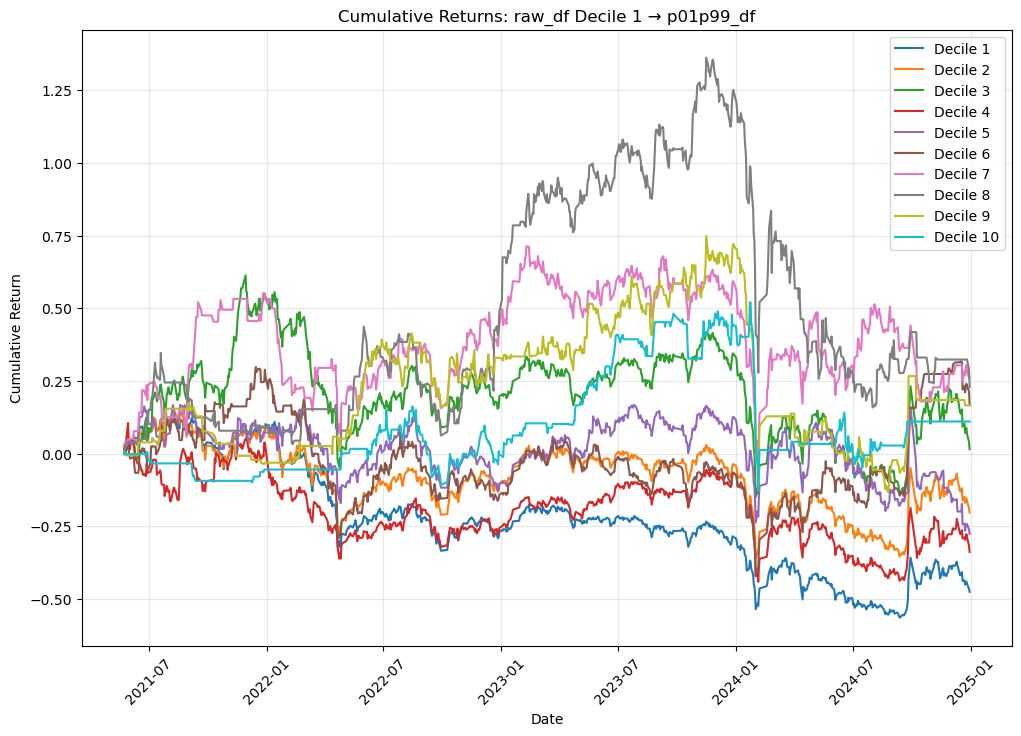

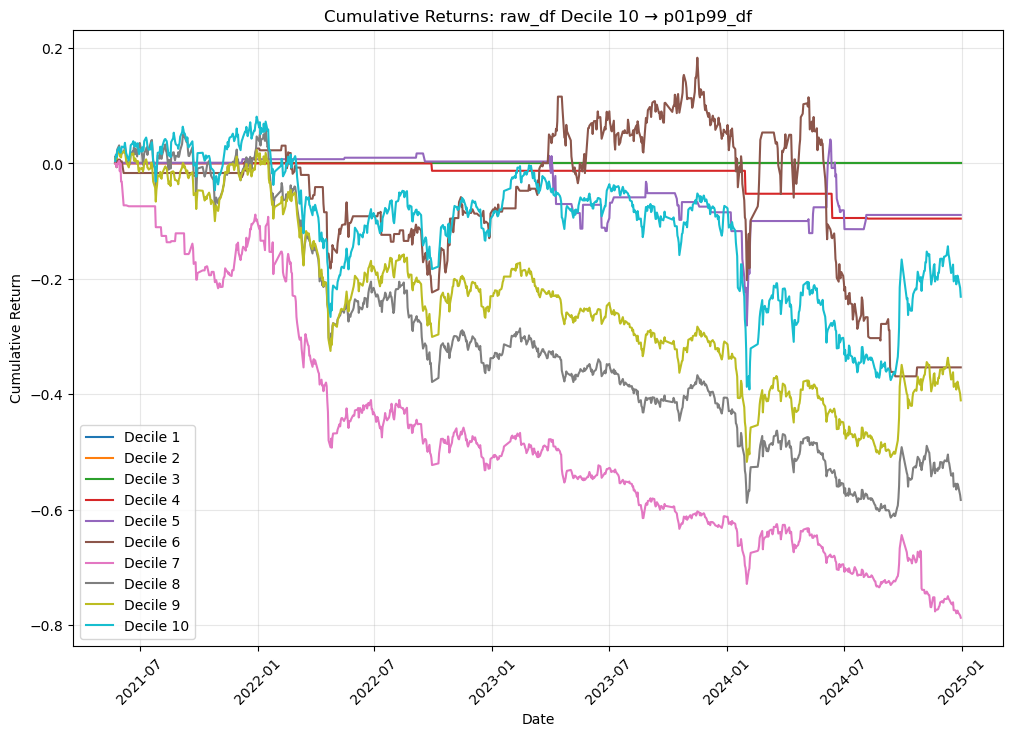

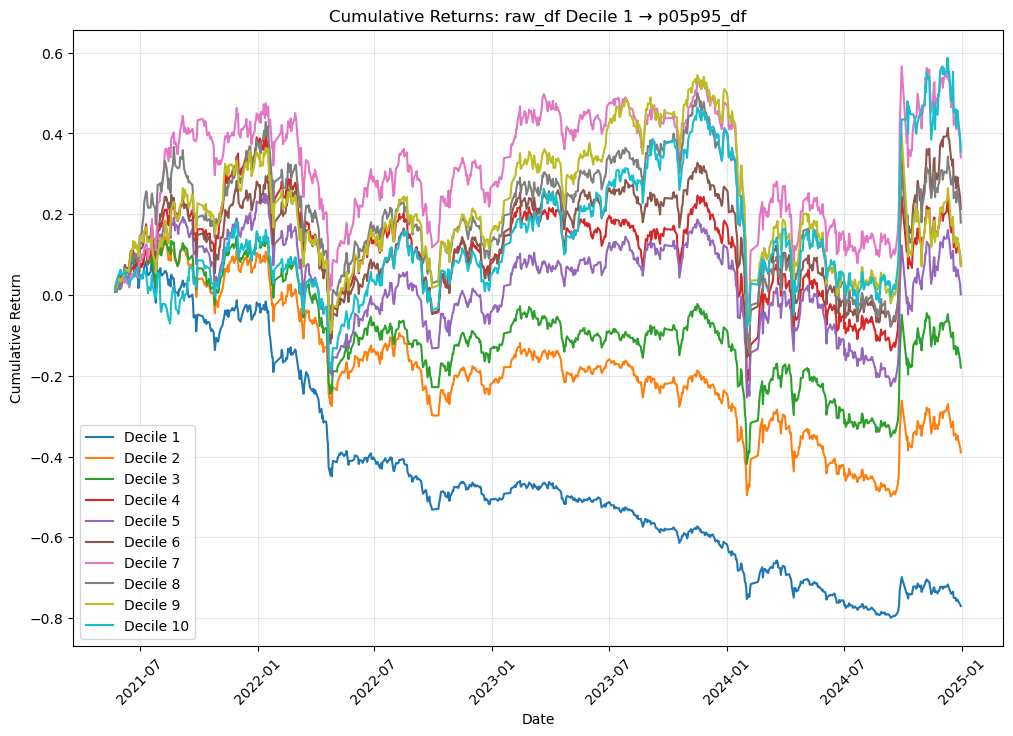

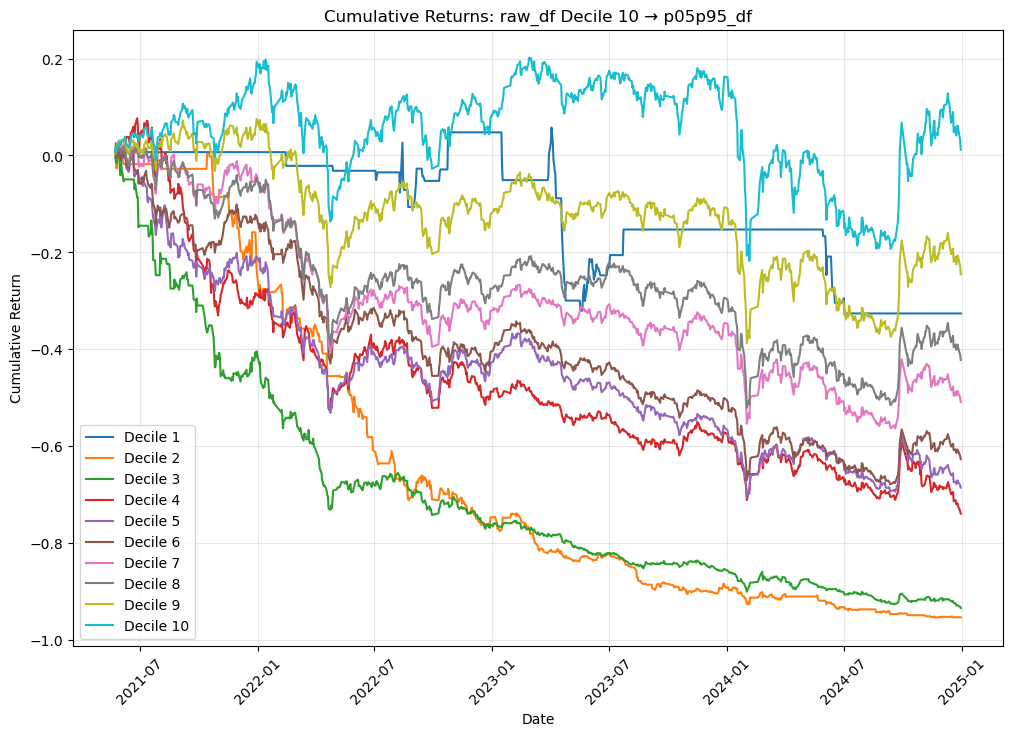

Average number of assets in each target decile:
Decile 1:
  raw_df(1) → p01p99_df: 326.8
  raw_df(10) → p01p99_df: 0.0
  raw_df(1) → p05p95_df: 142.1
  raw_df(10) → p05p95_df: 0.1
Decile 2:
  raw_df(1) → p01p99_df: 57.7
  raw_df(10) → p01p99_df: 0.0
  raw_df(1) → p05p95_df: 66.1
  raw_df(10) → p05p95_df: 1.5
Decile 3:
  raw_df(1) → p01p99_df: 18.1
  raw_df(10) → p01p99_df: 0.0
  raw_df(1) → p05p95_df: 44.3
  raw_df(10) → p05p95_df: 6.6
Decile 4:
  raw_df(1) → p01p99_df: 9.6
  raw_df(10) → p01p99_df: 0.0
  raw_df(1) → p05p95_df: 34.9
  raw_df(10) → p05p95_df: 13.1
Decile 5:
  raw_df(1) → p01p99_df: 5.9
  raw_df(10) → p01p99_df: 0.1
  raw_df(1) → p05p95_df: 30.3
  raw_df(10) → p05p95_df: 21.7
Decile 6:
  raw_df(1) → p01p99_df: 3.7
  raw_df(10) → p01p99_df: 1.4
  raw_df(1) → p05p95_df: 28.0
  raw_df(10) → p05p95_df: 32.1
Decile 7:
  raw_df(1) → p01p99_df: 2.5
  raw_df(10) → p01p99_df: 9.0
  raw_df(1) → p05p95_df: 25.3
  raw_df(10) → p05p95_df: 45.9
Decile 8:
  raw_df(1) → p01p99_df: 1.9
 

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

def analyze_cross_dataset_decile_returns(base_df, target_df, start_decile, return_col='1D'):
    """
    分析在base_df中属于特定分组的资产在target_df中各分组的收益率表现
    
    Parameters:
    base_df: 基准数据集
    target_df: 目标数据集
    start_decile: 在base_df中的起始分组 (1 or 10)
    return_col: 收益率列名
    
    Returns:
    DataFrame with cumulative returns for each target decile
    """
    # 确保两个数据集有相同的索引结构
    base_df = base_df.copy()
    target_df = target_df.copy()
    
    # 获取所有日期
    all_dates = sorted(base_df.index.get_level_values('date').unique())
    
    # 创建一个字典存储每个目标分组的日收益率序列
    decile_returns = {i: [] for i in range(1, 11)}
    decile_counts = {i: [] for i in range(1, 11)}  # 记录每个分组的资产数量
    
    # 对每个日期进行循环
    for date in all_dates:
        # 获取当前日期的数据
        base_day = base_df.xs(date, level='date')
        target_day = target_df.xs(date, level='date')
        
        # 找出在base_df中属于start_decile的所有资产
        start_assets = base_day[base_day['factor_quantile'] == start_decile].index.tolist()
        
        # 对于每个目标分组，计算平均收益率
        for target_decile in range(1, 11):
            # 找出在base_df中属于start_decile且在target_df中属于target_decile的资产
            assets_in_target = []
            returns_in_target = []
            
            for asset in start_assets:
                # 检查资产在target_df中是否存在且属于目标分组
                if asset in target_day.index:
                    if target_day.loc[asset, 'factor_quantile'] == target_decile:
                        assets_in_target.append(asset)
                        returns_in_target.append(target_day.loc[asset, return_col])
            
            # 计算这些资产的平均收益率
            if returns_in_target:
                avg_return = np.mean(returns_in_target)
                count = len(returns_in_target)
            else:
                avg_return = 0  # 如果没有资产在这个分组，收益率为0
                count = 0
                
            decile_returns[target_decile].append(avg_return)
            decile_counts[target_decile].append(count)
    
    # 创建一个DataFrame存储每个分组的累计收益率
    cum_returns = pd.DataFrame(index=all_dates)
    counts_df = pd.DataFrame(index=all_dates)
    
    for target_decile in range(1, 11):
        # 计算累计收益率
        cum_return = np.cumprod(np.array(decile_returns[target_decile]) + 1) - 1
        cum_returns[f'Decile {target_decile}'] = cum_return
        counts_df[f'Decile {target_decile}'] = decile_counts[target_decile]
    
    return cum_returns, counts_df

def plot_cross_dataset_returns(cum_returns, base_name, target_name, start_decile, figsize=(12, 8)):
    """
    绘制跨数据集分组收益率图
    """
    plt.figure(figsize=figsize)
    
    # 绘制每个目标分组的累计收益率
    for col in cum_returns.columns:
        plt.plot(cum_returns.index, cum_returns[col], label=col)
    
    plt.title(f'Cumulative Returns: {base_name} Decile {start_decile} → {target_name}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 格式化日期
    date_form = DateFormatter("%Y-%m")
    plt.gca().xaxis.set_major_formatter(date_form)
    plt.xticks(rotation=45)
    
    return plt

# 执行分析
# 1. raw_df第1组 → p01p99_df各组
cum_returns_1_to_p01p99, counts_1_to_p01p99 = analyze_cross_dataset_decile_returns(
    raw_df, p01p99_df, start_decile=1)
plot_1 = plot_cross_dataset_returns(
    cum_returns_1_to_p01p99, 'raw_df', 'p01p99_df', start_decile=1)
plot_1.savefig('raw_1_to_p01p99.png', dpi=300, bbox_inches='tight')
plot_1.show()

# 2. raw_df第10组 → p01p99_df各组
cum_returns_10_to_p01p99, counts_10_to_p01p99 = analyze_cross_dataset_decile_returns(
    raw_df, p01p99_df, start_decile=10)
plot_2 = plot_cross_dataset_returns(
    cum_returns_10_to_p01p99, 'raw_df', 'p01p99_df', start_decile=10)
plot_2.savefig('raw_10_to_p01p99.png', dpi=300, bbox_inches='tight')
plot_2.show()

# 3. raw_df第1组 → p05p95_df各组
cum_returns_1_to_p05p95, counts_1_to_p05p95 = analyze_cross_dataset_decile_returns(
    raw_df, p05p95_df, start_decile=1)
plot_3 = plot_cross_dataset_returns(
    cum_returns_1_to_p05p95, 'raw_df', 'p05p95_df', start_decile=1)
plot_3.savefig('raw_1_to_p05p95.png', dpi=300, bbox_inches='tight')
plot_3.show()

# 4. raw_df第10组 → p05p95_df各组
cum_returns_10_to_p05p95, counts_10_to_p05p95 = analyze_cross_dataset_decile_returns(
    raw_df, p05p95_df, start_decile=10)
plot_4 = plot_cross_dataset_returns(
    cum_returns_10_to_p05p95, 'raw_df', 'p05p95_df', start_decile=10)
plot_4.savefig('raw_10_to_p05p95.png', dpi=300, bbox_inches='tight')
plot_4.show()

# 可选：打印每个分组的资产数量统计
print("Average number of assets in each target decile:")
for i in range(1, 11):
    print(f"Decile {i}:")
    print(f"  raw_df(1) → p01p99_df: {np.mean(counts_1_to_p01p99[f'Decile {i}']):.1f}")
    print(f"  raw_df(10) → p01p99_df: {np.mean(counts_10_to_p01p99[f'Decile {i}']):.1f}")
    print(f"  raw_df(1) → p05p95_df: {np.mean(counts_1_to_p05p95[f'Decile {i}']):.1f}")
    print(f"  raw_df(10) → p05p95_df: {np.mean(counts_10_to_p05p95[f'Decile {i}']):.1f}")


In [70]:
def analyze_cross_dataset_decile_returns(base_df, target_df, start_decile, return_col='1D'):
    """
    分析在base_df中属于特定分组的资产在target_df中各分组的收益率表现
    
    Parameters:
    base_df: 基准数据集
    target_df: 目标数据集
    start_decile: 在base_df中的起始分组 (1 or 10)
    return_col: 收益率列名
    
    Returns:
    DataFrame with cumulative returns for each target decile
    """
    # 确保两个数据集有相同的索引结构
    base_df = base_df.copy()
    target_df = target_df.copy()
    
    # 获取所有日期
    all_dates = sorted(base_df.index.get_level_values('date').unique())
    
    # 创建一个字典存储每个目标分组的日收益率序列
    decile_returns = {i: [] for i in range(1, 11)}
    decile_counts = {i: [] for i in range(1, 11)}  # 记录每个分组的资产数量
    
    # 对每个日期进行循环
    for date in all_dates:
        # 获取当前日期的数据
        base_day = base_df.xs(date, level='date')
        target_day = target_df.xs(date, level='date')
        
        # 找出在base_df中属于start_decile的所有资产
        start_assets = base_day[base_day['factor_quantile'] == start_decile].index.tolist()
        
        # 对于每个目标分组，计算平均收益率
        for target_decile in range(1, 11):
            # 找出在base_df中属于start_decile且在target_df中属于target_decile的资产
            assets_in_target = []
            returns_in_target = []
            
            for asset in start_assets:
                # 检查资产在target_df中是否存在且属于目标分组
                if asset in target_day.index:
                    if target_day.loc[asset, 'factor_quantile'] == target_decile:
                        assets_in_target.append(asset)
                        returns_in_target.append(target_day.loc[asset, return_col])
            
            # 计算这些资产的平均收益率
            if returns_in_target:
                avg_return = np.mean(returns_in_target)
                count = len(returns_in_target)
            else:
                avg_return = 0  # 如果没有资产在这个分组，收益率为0
                count = 0
                
            decile_returns[target_decile].append(avg_return)
            decile_counts[target_decile].append(count)
    
    # 创建一个DataFrame存储每个分组的累计收益率
    cum_returns = pd.DataFrame(index=all_dates)
    counts_df = pd.DataFrame(index=all_dates)
    
    for target_decile in range(1, 11):
        # 计算累加收益率 (r1 + r2 + ...)
        cum_return = np.cumsum(np.array(decile_returns[target_decile]))
        cum_returns[f'Decile {target_decile}'] = cum_return
        counts_df[f'Decile {target_decile}'] = decile_counts[target_decile]
    
    return cum_returns, counts_df


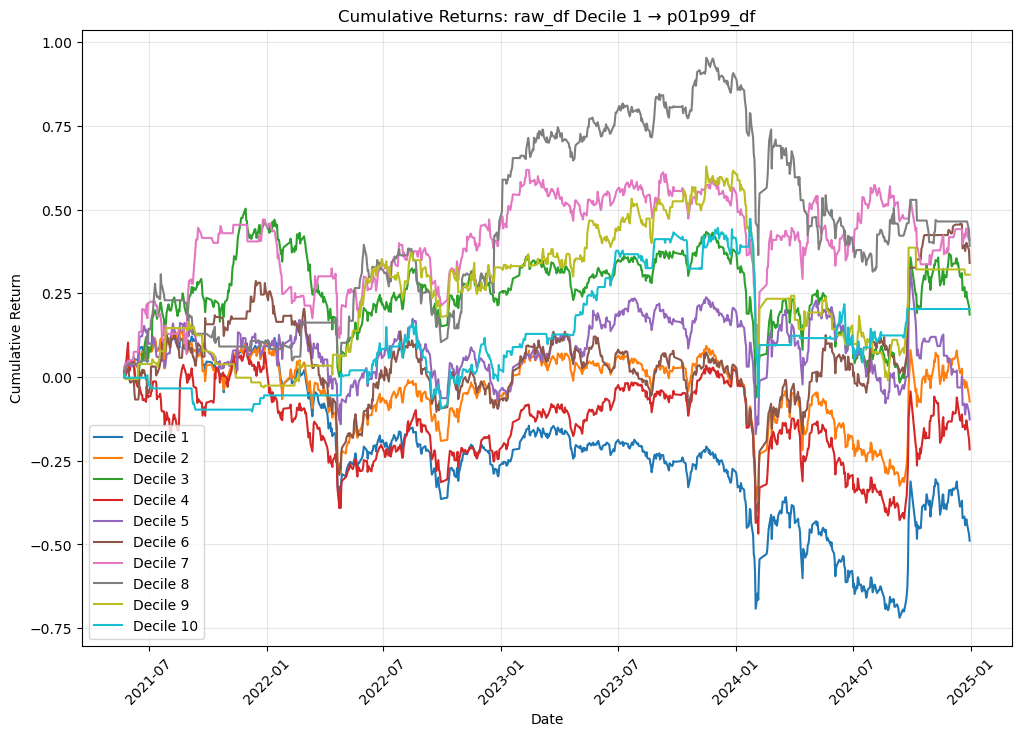

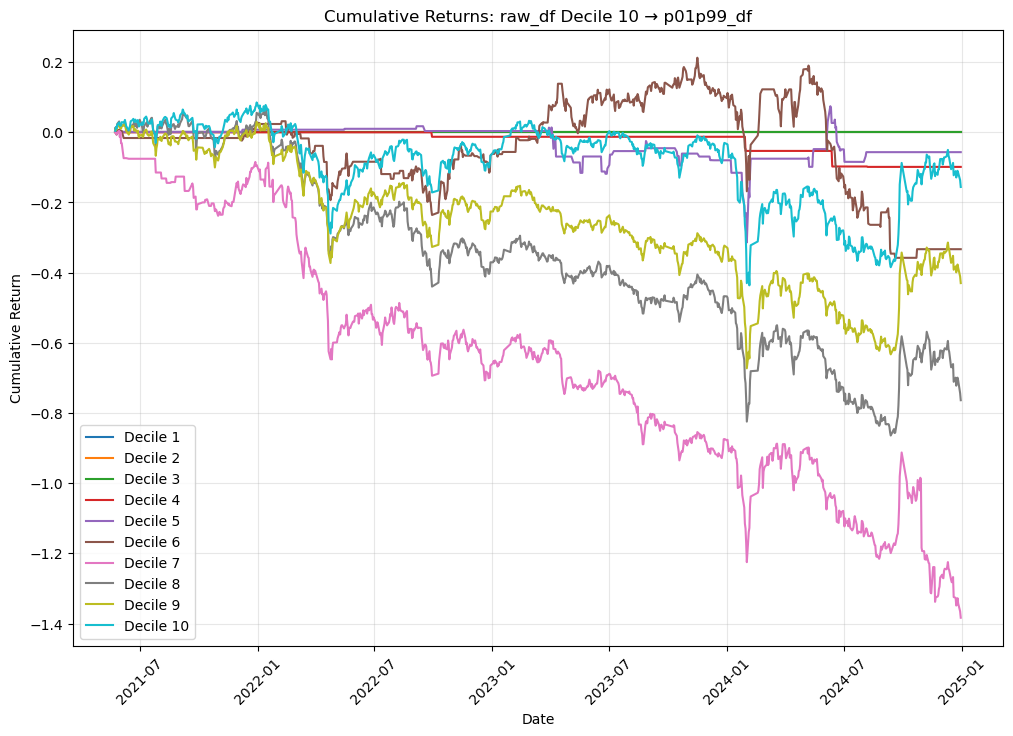

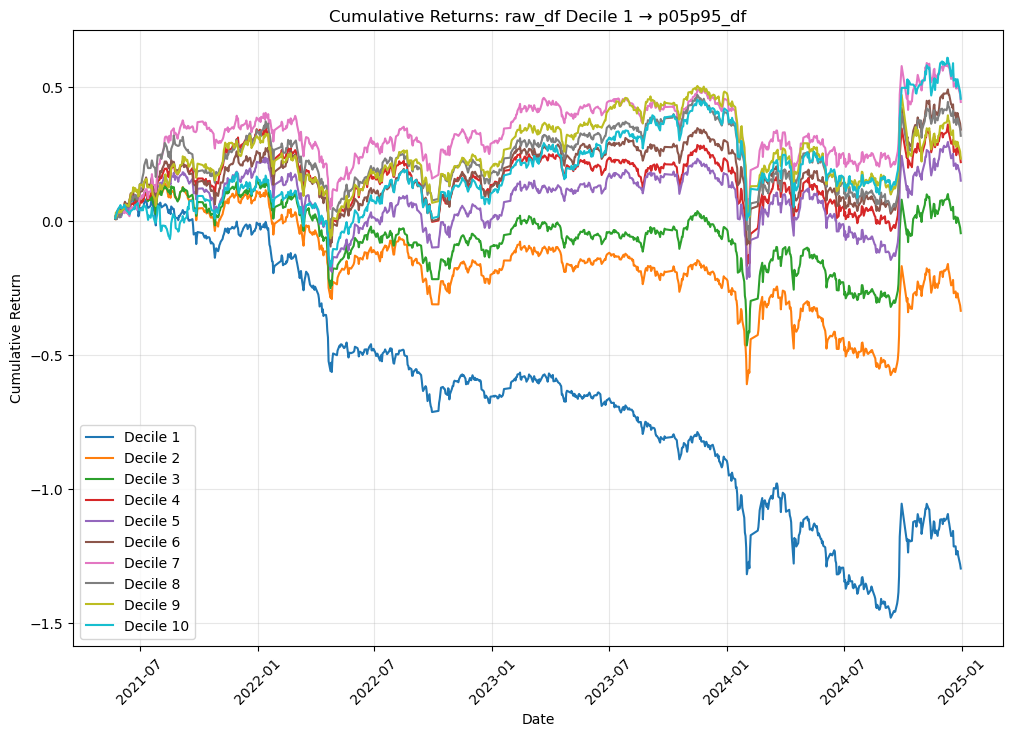

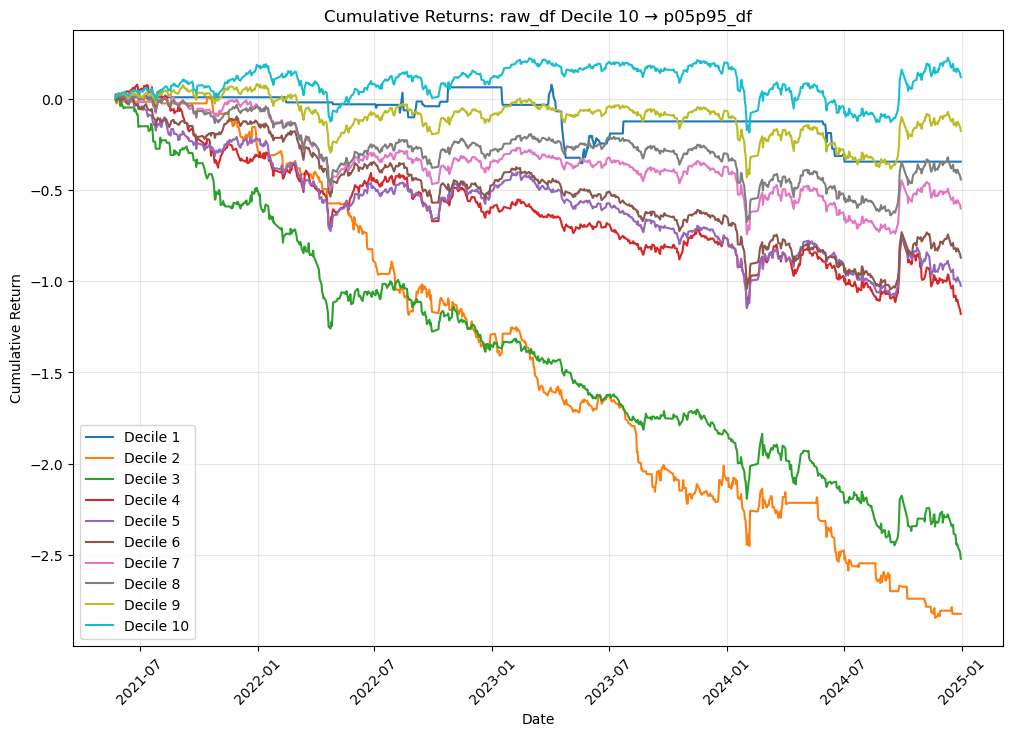

Average number of assets in each target decile:
Decile 1:
  raw_df(1) → p01p99_df: 326.8
  raw_df(10) → p01p99_df: 0.0
  raw_df(1) → p05p95_df: 142.1
  raw_df(10) → p05p95_df: 0.1
Decile 2:
  raw_df(1) → p01p99_df: 57.7
  raw_df(10) → p01p99_df: 0.0
  raw_df(1) → p05p95_df: 66.1
  raw_df(10) → p05p95_df: 1.5
Decile 3:
  raw_df(1) → p01p99_df: 18.1
  raw_df(10) → p01p99_df: 0.0
  raw_df(1) → p05p95_df: 44.3
  raw_df(10) → p05p95_df: 6.6
Decile 4:
  raw_df(1) → p01p99_df: 9.6
  raw_df(10) → p01p99_df: 0.0
  raw_df(1) → p05p95_df: 34.9
  raw_df(10) → p05p95_df: 13.1
Decile 5:
  raw_df(1) → p01p99_df: 5.9
  raw_df(10) → p01p99_df: 0.1
  raw_df(1) → p05p95_df: 30.3
  raw_df(10) → p05p95_df: 21.7
Decile 6:
  raw_df(1) → p01p99_df: 3.7
  raw_df(10) → p01p99_df: 1.4
  raw_df(1) → p05p95_df: 28.0
  raw_df(10) → p05p95_df: 32.1
Decile 7:
  raw_df(1) → p01p99_df: 2.5
  raw_df(10) → p01p99_df: 9.0
  raw_df(1) → p05p95_df: 25.3
  raw_df(10) → p05p95_df: 45.9
Decile 8:
  raw_df(1) → p01p99_df: 1.9
 

In [71]:

def plot_cross_dataset_returns(cum_returns, base_name, target_name, start_decile, figsize=(12, 8)):
    """
    绘制跨数据集分组收益率图
    """
    plt.figure(figsize=figsize)
    
    # 绘制每个目标分组的累计收益率
    for col in cum_returns.columns:
        plt.plot(cum_returns.index, cum_returns[col], label=col)
    
    plt.title(f'Cumulative Returns: {base_name} Decile {start_decile} → {target_name}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 格式化日期
    date_form = DateFormatter("%Y-%m")
    plt.gca().xaxis.set_major_formatter(date_form)
    plt.xticks(rotation=45)
    
    return plt

# 执行分析
# 1. raw_df第1组 → p01p99_df各组
cum_returns_1_to_p01p99, counts_1_to_p01p99 = analyze_cross_dataset_decile_returns(
    raw_df, p01p99_df, start_decile=1)
plot_1 = plot_cross_dataset_returns(
    cum_returns_1_to_p01p99, 'raw_df', 'p01p99_df', start_decile=1)
plot_1.savefig('raw_1_to_p01p99.png', dpi=300, bbox_inches='tight')
plot_1.show()

# 2. raw_df第10组 → p01p99_df各组
cum_returns_10_to_p01p99, counts_10_to_p01p99 = analyze_cross_dataset_decile_returns(
    raw_df, p01p99_df, start_decile=10)
plot_2 = plot_cross_dataset_returns(
    cum_returns_10_to_p01p99, 'raw_df', 'p01p99_df', start_decile=10)
plot_2.savefig('raw_10_to_p01p99.png', dpi=300, bbox_inches='tight')
plot_2.show()

# 3. raw_df第1组 → p05p95_df各组
cum_returns_1_to_p05p95, counts_1_to_p05p95 = analyze_cross_dataset_decile_returns(
    raw_df, p05p95_df, start_decile=1)
plot_3 = plot_cross_dataset_returns(
    cum_returns_1_to_p05p95, 'raw_df', 'p05p95_df', start_decile=1)
plot_3.savefig('raw_1_to_p05p95.png', dpi=300, bbox_inches='tight')
plot_3.show()

# 4. raw_df第10组 → p05p95_df各组
cum_returns_10_to_p05p95, counts_10_to_p05p95 = analyze_cross_dataset_decile_returns(
    raw_df, p05p95_df, start_decile=10)
plot_4 = plot_cross_dataset_returns(
    cum_returns_10_to_p05p95, 'raw_df', 'p05p95_df', start_decile=10)
plot_4.savefig('raw_10_to_p05p95.png', dpi=300, bbox_inches='tight')
plot_4.show()

# 可选：打印每个分组的资产数量统计
print("Average number of assets in each target decile:")
for i in range(1, 11):
    print(f"Decile {i}:")
    print(f"  raw_df(1) → p01p99_df: {np.mean(counts_1_to_p01p99[f'Decile {i}']):.1f}")
    print(f"  raw_df(10) → p01p99_df: {np.mean(counts_10_to_p01p99[f'Decile {i}']):.1f}")
    print(f"  raw_df(1) → p05p95_df: {np.mean(counts_1_to_p05p95[f'Decile {i}']):.1f}")
    print(f"  raw_df(10) → p05p95_df: {np.mean(counts_10_to_p05p95[f'Decile {i}']):.1f}")
